### TODO Recording:

##### Show HuggingFace

- Go to https://huggingface.co/
- Click on Models, Datasets, Spaces, Docs on top and show
- Back to Models, search for t5-small
- Show the model card

##### Show data

- Go to https://github.com/tuetschek/e2e-dataset


##### Colab
- Go to https://colab.research.google.com and show that we are logged in
- Create a new notebook and give it the right name
- Click on the folder icon on the left and upload the data there trainset.csv
- Collapse the left sidebar
- Click on Runtime and show that we are using a GPU
- Now we can start the notebook

In [1]:
!pip install transformers
!pip install sentencepiece
!pip install rouge-score


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24960 sha256=969284116ac1ebad06ea1fe2be1126b4b131841f809d4604c95a17be97cb38db
  Stored in directory: c:\users\nik-i7\appdata\local\pip\cache\wheels\24\55\6f\ebfc4cb176d1c9665da4e306e1705496206d08215c1acd9dde
Successfully built rouge-score



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import transformers

transformers.__version__

c:\Users\Nik-i7\miniconda3\envs\PilotPythonProject\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Nik-i7\miniconda3\envs\PilotPythonProject\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\Nik-i7\miniconda3\envs\PilotPythonProject\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


'4.34.0'

Importing required libraries

In [3]:
import torch

import pandas as pd

from transformers import T5Tokenizer, T5ForConditionalGeneration

from transformers.optimization import  Adafactor

from rouge_score import rouge_scorer

Loading our dataset specific to NLG
Link for the dataset-https://github.com/tuetschek/e2e-dataset

In [6]:
#restaurants_df = pd.read_csv("/content/trainset.csv")
restaurants_df = pd.read_csv("datasets/trainset.csv")

restaurants_df.sample(20)

,mr,ref
38616,"name[Strada], eatType[pub], food[Japanese], cu...",Strada is a five star sushi restaurant located...
14677,"name[Alimentum], food[Chinese], priceRange[hig...",The Alimentum is a Chinese food restaurant wit...
32197,"name[Aromi], eatType[coffee shop], food[Fast f...",Aromi is a family-friendly coffee shop that se...
25545,"name[The Rice Boat], food[English], customer r...",The Rice Boat is an English food serving place...
32422,"name[Travellers Rest Beefeater], eatType[resta...",A restaurant called Travellers Rest Beefeater ...
22897,"name[Blue Spice], food[Fast food], priceRange[...",The Blue Spice offers Fast food in riverside f...
39410,"name[The Wrestlers], food[English], priceRange...",The Wrestlers is an English food serving estab...
9651,"name[The Cambridge Blue], eatType[restaurant],...",Come sit down at The Cambridge Blue for some E...
29372,"name[Alimentum], food[English], priceRange[mor...",Alimentum is situated near the Yippee Noodle B...
32793,"name[The Eagle], priceRange[£20-25], customer ...",The Eagle is on the riverside. It costs £20 - ...


Checking the shape of the dataset

In [7]:
restaurants_df.shape

(42061, 2)

Checking one instance of data.
Column's description:
mr – textual meaning representation (MR)
ref – corresponding natural language utterance (human reference)

In [6]:
restaurants_df["mr"][3]

'name[The Mill], eatType[coffee shop], food[French], priceRange[£20-25], area[riverside], near[The Sorrento]'

In [8]:
restaurants_df["ref"][3]

'Located near The Sorrento is a French Theme eatery and coffee shop called The Mill, with a price range at £20-£25 it is in the riverside area.'

In [9]:
restaurants_df["mr"][1101]

'name[Browns Cambridge], food[French], area[riverside], familyFriendly[yes], near[The Sorrento]'

In [10]:
restaurants_df["ref"][1101]

'Browns Cambridge, a kid friendly French food restaurant, is located riverside near The Sorrento.'

We are sampling a fraction of  data from whole dataset in order to have faster training

In [11]:
restaurants_df_sampled = restaurants_df.sample(frac = 0.3)

restaurants_df_sampled.shape

(12618, 2)

Configuring and checking device

In [12]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cpu device


In [13]:
tokenizer = T5Tokenizer.from_pretrained("t5-small", legacy=False)

tokenizer

c:\Users\Nik-i7\miniconda3\envs\PilotPythonProject\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Nik-i7\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Using bos_token, but it is not set yet.
Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


T5Tokenizer(name_or_path='t5-small', vocab_size=32000, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42>', '<extra_id_43>', '<extra_id_4

In [14]:
tokenizer(["very budget-friendly restaurant"])

{'input_ids': [[182, 1487, 18, 4905, 2062, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1]]}

In [15]:
tokens = tokenizer.tokenize("very budget-friendly restaurant")

tokens

['▁very', '▁budget', '-', 'friendly', '▁restaurant']

In [16]:
ids = tokenizer.convert_tokens_to_ids(tokens)

ids

[182, 1487, 18, 4905, 2062]

In [17]:
model = T5ForConditionalGeneration.from_pretrained("t5-small", return_dict = True)

model = model.to(device)

We are generating output from the model without training and output seems to be random.

In [18]:
restaurants_df['mr'][10]

'name[Browns Cambridge], food[Fast food], area[riverside], familyFriendly[no], near[The Sorrento]'

In [19]:
model.eval()

# Batch size 1
input_ids = tokenizer.encode("name[Browns Cambridge], food[Fast food], area[riverside], familyFriendly[no], near[The Sorrento]", return_tensors = "pt")

input_ids

tensor([[  564,  6306,   279,  3623,    29,     7, 10096, 13679,   542,  6306,
           371,     9,     7,    17,   542, 13679,   616,  6306,  5927,    49,
          1583, 13679,   384, 17701,   120,  6306,    29,    32, 13679,  1084,
          6306,   634,   264,    52,  5320,    32,   908,     1]])

In [20]:
input_ids = input_ids.to(device)

outputs = model.generate(input_ids, max_new_tokens=50)

outputs

tensor([[    0,   465,    51,  6306,   279,  3623,    29,     7, 10096, 13679,
           542,  6306,   371,     9,     7,    17,   542, 13679,   616,  6306,
          5927,    49,  1583, 13679,   384, 17701,   120,  6306,    29,    32,
         13679,  1084,  6306,   634,   264,    52,  5320,    32,   908,     1]])

In [21]:
tokenizer.decode(outputs[0])

'<pad> Nom[Browns Cambridge], food[Fast food], area[riverside], familyFriendly[no], near[The Sorrento]</s>'

In [22]:
# Define the reference summary and predicted summary
reference_text = "Bibimbap House is a moderately priced restaurant who's main cuisine is English food."
predicted_text = "Bibimbap House is a moderately priced restaurant who's main cuisine is English food."

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer = True)

# Compute ROUGE scores
rouge_scores = scorer.score(reference_text, predicted_text)

# Print ROUGE scores
for metric, scores in rouge_scores.items():
    print(f'{metric}:')
    print(f'  Precision: {scores.precision}')
    print(f'  Recall: {scores.recall}')
    print(f'  F1 Score: {scores.fmeasure}')

rouge1:
  Precision: 1.0
  Recall: 1.0
  F1 Score: 1.0
rouge2:
  Precision: 1.0
  Recall: 1.0
  F1 Score: 1.0
rougeL:
  Precision: 1.0
  Recall: 1.0
  F1 Score: 1.0


In [23]:
# Define the reference summary and predicted summary
reference_text = "Bibimbap House is a moderately priced restaurant who's main cuisine is English food."
predicted_text = "Bibimbap House is a fairly priced restaurant serving English food"

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer = True)

# Compute ROUGE scores
rouge_scores = scorer.score(reference_text, predicted_text)

# Print ROUGE scores
for metric, scores in rouge_scores.items():
    print(f'{metric}:')
    print(f'  Precision: {scores.precision}')
    print(f'  Recall: {scores.recall}')
    print(f'  F1 Score: {scores.fmeasure}')

rouge1:
  Precision: 0.8
  Recall: 0.5714285714285714
  F1 Score: 0.6666666666666666
rouge2:
  Precision: 0.5555555555555556
  Recall: 0.38461538461538464
  F1 Score: 0.4545454545454546
rougeL:
  Precision: 0.8
  Recall: 0.5714285714285714
  F1 Score: 0.6666666666666666


In [24]:
# Define the reference summary and predicted summary
reference_text = "Bibimbap House is a moderately priced restaurant who's main cuisine is English food."
predicted_text = "House is a restaurant serving French food"

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer = True)

# Compute ROUGE scores
rouge_scores = scorer.score(reference_text, predicted_text)

# Print ROUGE scores
for metric, scores in rouge_scores.items():
    print(f'{metric}:')
    print(f'  Precision: {scores.precision}')
    print(f'  Recall: {scores.recall}')
    print(f'  F1 Score: {scores.fmeasure}')

rouge1:
  Precision: 0.7142857142857143
  Recall: 0.35714285714285715
  F1 Score: 0.4761904761904762
rouge2:
  Precision: 0.3333333333333333
  Recall: 0.15384615384615385
  F1 Score: 0.21052631578947367
rougeL:
  Precision: 0.7142857142857143
  Recall: 0.35714285714285715
  F1 Score: 0.4761904761904762


Initializing the Adafactor optimizer with parameter values suggested for t5

In [25]:
optimizer = Adafactor(
    model.parameters(),
    lr = 1e-6,
    eps = (1e-30, 1e-3),
    clip_threshold = 1.0,
    decay_rate = -0.8,
    beta1 = None,
    weight_decay = 0.0,
    relative_step = False,
    scale_parameter = False,
    warmup_init = False
)

Splitting data into Training and Validation sets

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(restaurants_df_sampled, test_size = 0.2, random_state = 123)

X_train.shape, X_val.shape

((10094, 2), (2524, 2))

In [27]:
X_val

,mr,ref
36921,"name[Fitzbillies], eatType[coffee shop], food[...",Fitzbillies coffee shop providers of fine Indi...
5467,"name[Alimentum], food[Fast food], priceRange[l...",Alimentum is a Fast food restaurant located in...
19176,"name[Midsummer House], food[Italian], customer...",For a nice three star meal try the Midsummer H...
23538,"name[Browns Cambridge], food[French], priceRan...","There is a Browns Cambridge ,with an average c..."
7251,"name[Midsummer House], food[French], priceRang...",Midsummer House offers food and wine and is ne...
...,...,...
34615,"name[The Golden Curry], food[Italian], custome...",The Golden Curry is an Italian restaurant with...
9896,"name[The Punter], food[French], priceRange[les...",Cheap French cuisine is served at a restaurant...
506,"name[The Cambridge Blue], eatType[pub], food[E...",Located near the Café Brazil you will find the...
41002,"name[Blue Spice], priceRange[less than £20], a...",Blue Spice is near the riverside and has price...


Setting parameters for training

In [28]:
batch_size = 8

num_of_epochs = 10

In [29]:
loss_stats = {
    "train": [],
    "val": []
}

Model training is done

In [30]:
# Sets the module in training mode
model.train()

for epoch in range(0, num_of_epochs + 1):
    print("Running epoch: {}".format(epoch + 1))

    train_running_loss = 0

    num_of_batches = len(X_train) / batch_size

    for i in range(int(num_of_batches)):
        X_train_batch = []
        y_train_batch = []

        batch_df = X_train[i * batch_size: i * batch_size + batch_size]

        for _, row in batch_df.iterrows():
            X_train_row = row["mr"]
            y_train_row = row["ref"]

            X_train_batch.append(X_train_row)
            y_train_batch.append(y_train_row)

        X_train_batch = tokenizer.batch_encode_plus(X_train_batch, padding = True, truncation = True,
                                                    max_length = 256, return_tensors = "pt")["input_ids"]
        y_train_batch = tokenizer.batch_encode_plus(y_train_batch, padding = True, truncation = True,
                                                    max_length = 256, return_tensors = "pt")["input_ids"]

        X_train_batch = X_train_batch.to(device)
        y_train_batch = y_train_batch.to(device)

        # clear out the gradients of all Variables
        optimizer.zero_grad()

        # Forward propogation
        train_outputs = model(input_ids = X_train_batch, labels = y_train_batch)

        train_loss = train_outputs.loss
        train_loss.backward()

        train_loss_num = train_loss.item()
        train_running_loss += train_loss_num

        #updating the params
        optimizer.step()

    train_loss = train_running_loss / int(num_of_batches)

    # VALIDATION
    with torch.no_grad():
         val_running_loss = 0

         model.eval()
         num_of_batches = len(X_val)/batch_size

         for i in range(int(num_of_batches)):
             X_val_batch = []
             y_val_batch = []

             val_batch_df = X_val[i * batch_size: i * batch_size + batch_size]

             for idx, row in val_batch_df.iterrows():
                 X_val_row = row["mr"]
                 y_val_row = row["ref"]

                 X_val_batch.append(X_val_row)
                 y_val_batch.append(y_val_row)

             X_val_batch = tokenizer.batch_encode_plus(X_val_batch, padding = True, truncation = True,
                                                       max_length = 256, return_tensors = "pt")["input_ids"]
             y_val_batch = tokenizer.batch_encode_plus(y_val_batch, padding = True, truncation = True,
                                                       max_length = 256, return_tensors = "pt")["input_ids"]
             X_val_batch = X_val_batch.to(device)
             y_val_batch = y_val_batch.to(device)

             val_outputs = model(input_ids = X_val_batch, labels = y_val_batch)

             val_loss = val_outputs.loss

             val_loss_num = val_loss.item()
             val_running_loss += val_loss_num

    val_loss = val_running_loss / int(num_of_batches)

    loss_stats["train"].append(train_loss)
    loss_stats["val"].append(val_loss)

    print(f"Epoch {epoch+1:01}: | Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f}")

Running epoch: 1
Epoch 1: | Train Loss: 4.341 | Val Loss: 2.559
Running epoch: 2


In [69]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats). \
    reset_index().melt(id_vars = ["index"]). \
    rename(columns = {"index": "epochs"})

train_val_loss_df.head()

,epochs,variable,value
0,0,train,4.388359
1,1,train,2.252302
2,2,train,1.801845
3,3,train,1.560804
4,4,train,1.430088


In [70]:
train_val_loss_df.tail()

,epochs,variable,value
17,6,val,1.287142
18,7,val,1.246493
19,8,val,1.214407
20,9,val,1.187951
21,10,val,1.163588


Text(0.5, 1.0, 'Train-Val Loss vs Epoch')

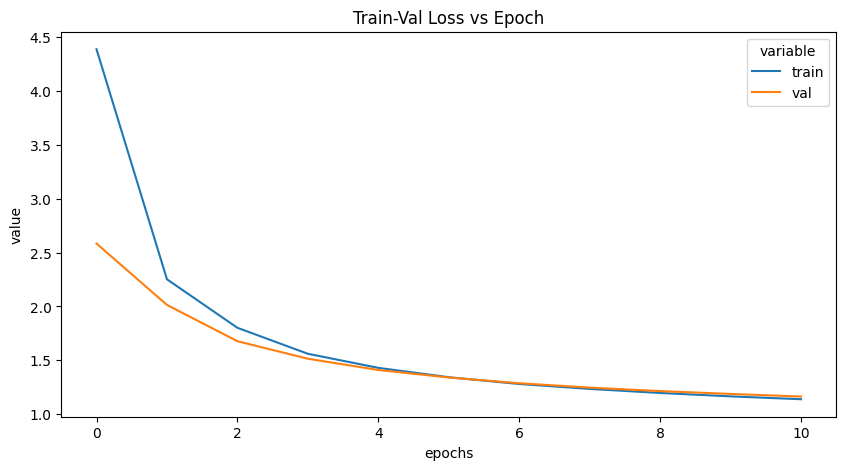

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 5))

sns.lineplot(data = train_val_loss_df,
             x = "epochs", y = "value",
             hue = "variable"
).set_title("Train-Val Loss vs Epoch")

In [72]:
model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [73]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer = True)

In [95]:
X_val.sample(5)

,mr,ref
31608,"name[The Phoenix], food[Indian], customer rati...",Situated on the riverside is The Phoenix. The ...
22184,"name[The Olive Grove], eatType[pub], food[Fast...",There is a cheap pub that provides fast food c...
7990,"name[Cotto], priceRange[high], area[riverside]...",Cotto is a high priced place in the riverside ...
38987,"name[Loch Fyne], eatType[restaurant], food[Ita...",Loch Fyne is an Italian restaurant that is not...
18146,"name[Alimentum], food[Fast food], priceRange[m...",In the riverside are is the moderately priced ...


In [77]:
X_val["mr"][16677]

'name[Midsummer House], food[French], priceRange[cheap], customer rating[5 out of 5], near[All Bar One]'

In [78]:
input_ids = tokenizer.encode(X_val["mr"][16677], return_tensors = "pt")

input_ids = input_ids.to(device)

outputs = model.generate(input_ids, max_new_tokens=100)

predicted_text = tokenizer.decode(outputs[0])

predicted_text

'<pad> The Midsummer House is a French restaurant with a 5-star rating. It is near All Bar One.</s>'

In [79]:
predicted_text = predicted_text.strip(' <>/pads')

predicted_text

'The Midsummer House is a French restaurant with a 5-star rating. It is near All Bar One.'

In [81]:
reference_text = X_val["ref"][16677]

reference_text

'Midsummer House, near to All Bar One in Cambridge, has a low-priced menu of wines, cheeses, soups and breads.'

In [82]:
rouge_scores = scorer.score(reference_text, predicted_text)

for metric, scores in rouge_scores.items():
    print(f'{metric}:')
    print(f'  Precision: {scores.precision}')
    print(f'  Recall: {scores.recall}')
    print(f'  F1 Score: {scores.fmeasure}')

rouge1:
  Precision: 0.3888888888888889
  Recall: 0.35
  F1 Score: 0.36842105263157887
rouge2:
  Precision: 0.17647058823529413
  Recall: 0.15789473684210525
  F1 Score: 0.16666666666666669
rougeL:
  Precision: 0.3333333333333333
  Recall: 0.3
  F1 Score: 0.3157894736842105


In [90]:
def generate_text_and_compute_score(random_index):

  input_ids = tokenizer.encode(X_val["mr"][random_index], return_tensors = "pt")
  input_ids = input_ids.to(device)
  outputs = model.generate(input_ids, max_new_tokens=100)

  predicted_text = tokenizer.decode(outputs[0])
  predicted_text = predicted_text.strip(' <>/pads')

  reference_text = X_val["ref"][random_index]

  rouge_scores = scorer.score(reference_text, predicted_text)

  print("MR: ", X_val["mr"][random_index])
  print("Reference: ", reference_text)
  print("Predicted: ", predicted_text)

  for metric, scores in rouge_scores.items():
      print(f'{metric}:')
      print(f'  Precision: {scores.precision}')
      print(f'  Recall: {scores.recall}')
      print(f'  F1 Score: {scores.fmeasure}')

In [91]:
generate_text_and_compute_score(10533)

MR:  name[The Golden Curry], food[Indian], customer rating[average], area[city centre], familyFriendly[no], near[Café Rouge]
Reference:  The Golden Curry offers Indian food located in the centre of the city near Café Rouge. It is not family friendly and only has an average customer rating.
Predicted:  The Golden Curry is a food Indian restaurant near Café Rouge. It is a family friendly restaurant.
rouge1:
  Precision: 0.7058823529411765
  Recall: 0.42857142857142855
  F1 Score: 0.5333333333333333
rouge2:
  Precision: 0.4375
  Recall: 0.25925925925925924
  F1 Score: 0.3255813953488372
rougeL:
  Precision: 0.6470588235294118
  Recall: 0.39285714285714285
  F1 Score: 0.4888888888888888


In [93]:
generate_text_and_compute_score(37100)

MR:  name[The Olive Grove], eatType[pub], food[Fast food], priceRange[moderate], area[riverside], familyFriendly[no]
Reference:  The Olive Grove serves Fast food in a pub. Not kid friendly and located in riverside. Priced moderate.
Predicted:  The Olive Grove is a family-friendly pub that serves fast food. It is located in the riverside area.
rouge1:
  Precision: 0.631578947368421
  Recall: 0.6666666666666666
  F1 Score: 0.6486486486486486
rouge2:
  Precision: 0.2777777777777778
  Recall: 0.29411764705882354
  F1 Score: 0.28571428571428575
rougeL:
  Precision: 0.47368421052631576
  Recall: 0.5
  F1 Score: 0.4864864864864865


In [94]:
generate_text_and_compute_score(41105)

MR:  name[The Cambridge Blue], eatType[restaurant], food[English], customer rating[1 out of 5]
Reference:  The Cambridge Blue is a low rated English food restaurant.
Predicted:  The Cambridge Blue is a restaurant that is rated 1 out of 5 by customer. It is based on the customer rating.
rouge1:
  Precision: 0.3181818181818182
  Recall: 0.7
  F1 Score: 0.4375
rouge2:
  Precision: 0.19047619047619047
  Recall: 0.4444444444444444
  F1 Score: 0.26666666666666666
rougeL:
  Precision: 0.2727272727272727
  Recall: 0.6
  F1 Score: 0.37499999999999994


In [96]:
generate_text_and_compute_score(7990)

MR:  name[Cotto], priceRange[high], area[riverside], near[All Bar One]
Reference:  Cotto is a high priced place in the riverside area, near the All Bar One.
Predicted:  Cotto is a high price-rive, located in the riverside, near All Bar One.
rouge1:
  Precision: 0.8571428571428571
  Recall: 0.8
  F1 Score: 0.8275862068965518
rouge2:
  Precision: 0.6153846153846154
  Recall: 0.5714285714285714
  F1 Score: 0.5925925925925927
rougeL:
  Precision: 0.8571428571428571
  Recall: 0.8
  F1 Score: 0.8275862068965518
